In [1]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ranitadey21","key":"955de21b3dc88615ac3ff170962b367b"}'}

In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
... resuming from 1231028224 bytes (1232337211 bytes left) ...
100% 2.29G/2.29G [00:54<00:00, 23.4MB/s]
100% 2.29G/2.29G [00:54<00:00, 22.6MB/s]


In [6]:
!unzip chest-xray-pneumonia.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: ./data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: ./data/chest_xr

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "./data/chest_xray/train"
val_dir = "./data/chest_xray/val"
test_dir = "./data/chest_xray/test"

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_generator = test_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 117s 630ms/step - accuracy: 0.7431 - loss: 0.5790 - val_accuracy: 0.5000 - val_loss: 0.7399
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.7520 - loss: 0.5163 - val_accuracy: 0.5000 - val_loss: 0.8938
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 705ms/step - accuracy: 0.7663 - loss: 0.4724 - val_accuracy: 0.5625 - val_loss: 0.7044
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.7732 - loss: 0.4542 - val_accuracy: 0.5625 - val_loss: 0.7541
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 601ms/step - accuracy: 0.7787 - loss: 0.4321 - val_accuracy: 0.6250 - val_loss: 0.6528
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.7630 - loss: 0.4411 - val_accuracy: 0.5625 - val_loss: 0.8621
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 591ms/step - accuracy: 0.7895 - loss: 0.4065 - val_accuracy: 0.6250 - val_loss: 0.7212
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 595ms/step - accuracy: 0.7798 - loss

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.7594 - loss: 0.4652
Test Accuracy: 74.20%


In [11]:
model.save("pneumonia_resnet50_model.h5")

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary labels


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 471ms/step


In [13]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.20      0.25       234
           1       0.61      0.76      0.68       390

    accuracy                           0.55       624
   macro avg       0.47      0.48      0.46       624
weighted avg       0.50      0.55      0.51       624



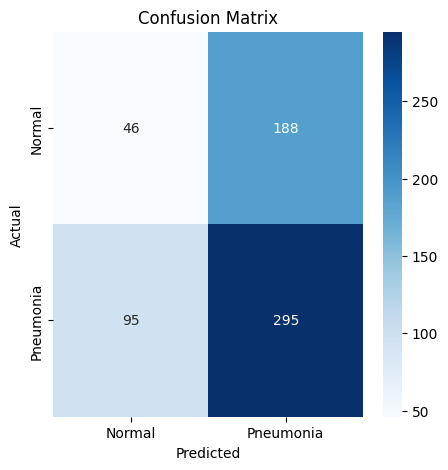

In [14]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

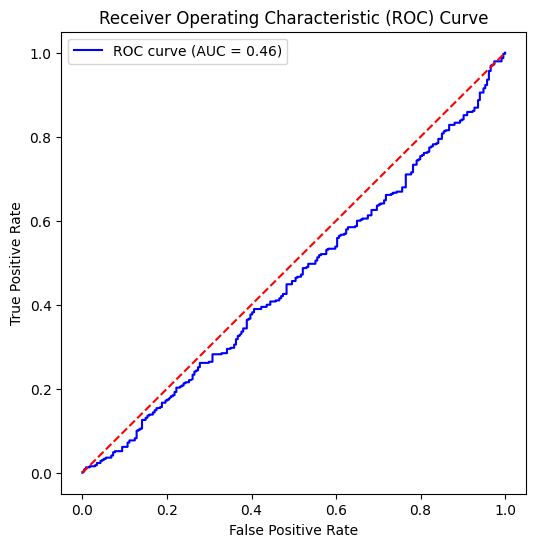

In [15]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()